In [1]:
# Import necessary libraries
import os
from pathlib import Path
import torch
from PIL import Image
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

In [7]:
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths to the folders
solvable_path = Path('./17')
unsolvable_path = Path('./17_unsolvable_same_wall_count')
max_images = 10000  # Total number of images to load (150 solvable + 150 unsolvable)

# Calculate the number of images to load per class
images_per_class = max_images // 2

def load_and_label_images(folder_path, label, max_images):
    images = []
    labels = []
    count = 0
    for img_path in folder_path.glob('*.png'):
        if count >= max_images:
            break
        img_array = np.array(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE))
        img_array = img_array/255
        images.append(img_array)
        labels.append(label)
        count += 1
    return images, labels   

Total images loaded: 10000
Total labels loaded: 10000


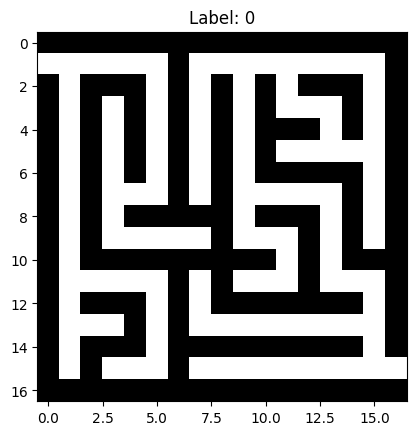

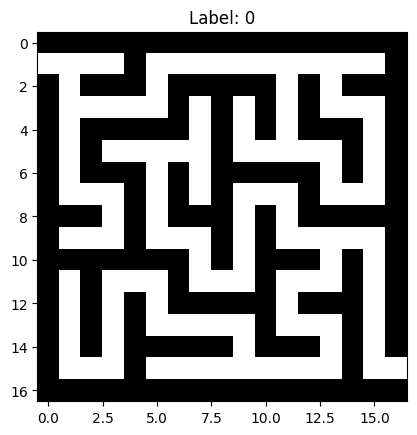

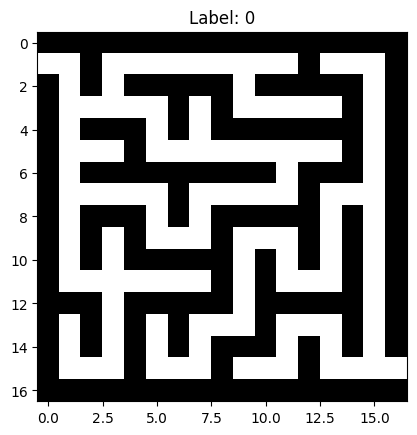

In [8]:

# Load solvable mazes
solvable_images, solvable_labels = load_and_label_images(solvable_path, 1, images_per_class)

# Load unsolvable mazes
unsolvable_images, unsolvable_labels = load_and_label_images(unsolvable_path, 0, images_per_class)

# Combine images and labels
all_images = solvable_images + unsolvable_images
all_labels = solvable_labels + unsolvable_labels

# Verify that images are loaded correctly
print(f"Total images loaded: {len(all_images)}")
print(f"Total labels loaded: {len(all_labels)}")

In [25]:

def maze_to_graph(maze_image):
    # maze_image is a numpy array with values 0 or 1
    maze = maze_image.astype(int)
    height, width = maze.shape
    nodes = []
    node_idx = {}
    idx = 0

    # Create nodes for free path cells
    for i in range(height):
        for j in range(width):
            if maze[i, j] == 1:  # Path
                node_idx[(i, j)] = idx
                # Use normalized coordinates as node features
                nodes.append([i / height, j / width])
                idx += 1

    if len(nodes) == 0:
        # If no path nodes are found, return an empty graph
        data = Data()
        return data

    # Create edges between adjacent free cells
    edge_index = [[], []]
    for (i, j), idx in node_idx.items():
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + dx, j + dy
            if 0 <= ni < height and 0 <= nj < width and maze[ni, nj] == 1:
                neighbor_idx = node_idx.get((ni, nj))
                if neighbor_idx is not None:
                    edge_index[0].append(idx)
                    edge_index[1].append(neighbor_idx)

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    x = torch.tensor(nodes, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index)
    
    return data

In [26]:

def maze_to_graph_implicit(maze_image):
    # maze_image is a numpy array with values 0 or 1
    maze = maze_image.astype(int)
    rows, cols = np.nonzero(maze)
    edge_index = torch.tensor([rows, cols], dtype=torch.long)
    num_nodes = len(maze)
    node_features = torch.eye(num_nodes)
    data = Data(x=node_features, edge_index=edge_index)
    return data

In [27]:
# Convert images to graph data
graph_data_list = []
valid_labels = []
for image, label in tqdm(zip(all_images, all_labels), desc="Converting images to graphs", total=len(all_images)):
    data = maze_to_graph_implicit(image) #or maze_to_graph for method 1
    if data.x is not None and data.edge_index.size(1) > 0:  # Ensure data is valid
        graph_data_list.append(data)
        valid_labels.append(label)
    else:
        print("Encountered an empty graph or graph with no edges; skipping.")

# Adjust labels accordingly
labels = torch.tensor(valid_labels, dtype=torch.long)

# Verify label distribution
from collections import Counter
label_counts = Counter(labels.tolist())
print(f"Label distribution: {label_counts}")

Converting images to graphs: 100%|██████████| 10000/10000 [00:00<00:00, 11779.32it/s]

Label distribution: Counter({1: 5000, 0: 5000})


In [29]:
# Split dataset
train_data, test_data, train_labels, test_labels = train_test_split(
    graph_data_list, labels, test_size=0.2, stratify=labels, random_state=42)

# Assign labels to data objects
for data, label in zip(train_data, train_labels):
    data.y = label
for data, label in zip(test_data, test_labels):
    data.y = label

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

# Define the GNN model

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(17, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 2)  # Output: 2 classes

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # Global pooling
        x = self.lin(x)
        return x

# Initialize the model and move it to the device
model = GCN(hidden_channels=128).to(device)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss

def test(loader):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            total += data.num_graphs
    return correct / total

# Training loop
epochs = 5
for epoch in range(1, epochs + 1):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Print final evaluation
print("Training complete.")
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

C:\Users\shade_of_ox\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.6936, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 02, Loss: 0.6933, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 03, Loss: 0.6933, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 04, Loss: 0.6932, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 05, Loss: 0.6933, Train Acc: 0.5000, Test Acc: 0.5000
Training complete.
Final Training Accuracy: 0.5000
Final Test Accuracy: 0.5000
